## __Author__ : Theophilus Siameh
    __Pytoch__ = Image Classification of Mask/No-Mask
    __Comment__ = Pattern Recognition Project
    __Email__ = ts2434@msstate.edu
    __Twitter__ = @tsiameh
    __copyright__ = 'Copyright (C) 2021'
    __version__ = 1.0

In [311]:
import pyfiglet
result = pyfiglet.figlet_format("Mask Classification")
print(result)

 __  __           _    
|  \/  | __ _ ___| | __
| |\/| |/ _` / __| |/ /
| |  | | (_| \__ \   < 
|_|  |_|\__,_|___/_|\_\
                       
  ____ _               _  __ _           _   _             
 / ___| | __ _ ___ ___(_)/ _(_) ___ __ _| |_(_) ___  _ __  
| |   | |/ _` / __/ __| | |_| |/ __/ _` | __| |/ _ \| '_ \ 
| |___| | (_| \__ \__ \ |  _| | (_| (_| | |_| | (_) | | | |
 \____|_|\__,_|___/___/_|_| |_|\___\__,_|\__|_|\___/|_| |_|
                                                           



In [208]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

import os
import shutil
import cv2
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import argparse

from imutils import paths
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Hyperparameters Configurations

In [243]:
def argsParser():
    '''Hyper-parameters Settings'''
    parser = argparse.ArgumentParser(description='Mask/NoMask Classifier')
    parser.add_argument('--step_size', default=7, type=int, help = "Period of learning rate decay")
    parser.add_argument('--momentum', default=0.9, type=float, help = "Momentum")
    parser.add_argument('--gamma', default=0.1, type=float, help = "Multiplicative factor of learning rate decay")
    parser.add_argument('--learning_rate', default=0.001, type=float, help='Initial learning rate')
    parser.add_argument('--num_epochs', default=10, type=int, help='Number of epochs')
    parser.add_argument('--num_workers', default=2, type=int, help = "Number of Workers")
    parser.add_argument('--batch_size', default=4, type=int, help = "Batch Size")
    parser.add_argument('--val_split',default=0.30, type=float, help='Validation Split')
    parser.add_argument('--num_classes',default=2, type=int, help='Number of Output Classes (0/1)')
    parser.add_argument('--cpu',default='cpu', type=str, help='CPU')
    parser.add_argument('--gpu',default='cuda', type=str, help='GPU')
    parser.add_argument('--IMG_WIDTH',default=224, type=int, help='Image Width')
    parser.add_argument('--IMG_HEIGHT',default=224, type=int, help='Image Height')

    args = parser.parse_args(args=[])
    return args

In [240]:
FLAGS = argsParser()

## Device Configuration: CPU or GPU

In [215]:
device = torch.device(FLAGS.gpu if torch.cuda.is_available() else FLAGS.cpu)

## Directory Structure

<pre>
└── Data
    └── MASK_NOMASK
        ├── test
        │   ├── 
        │   │   ├── 1.jpg
        │   │   ├── 2.jpg
        │   │   └── ... (# files)
        │   └── 
        │       ├── 500.jpg
        │       ├── 501.jpg
        │       └── ... (# files)       
        │           
        └── train
            ├── MASK
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (# files)
            └── NO_MASK
                ├── 0.jpg
                ├── 1.jpg
                └── ... (# files)</pre>

## Directory Configurations

In [92]:
dir_path  = "Mask_NoMask/"
test_dir  = 'test'
train_dir = 'train'

root = f"/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/{dir_path}"
test_path  = root + test_dir
train_path = root + train_dir

## Convert all test images to .png or .jpg

In [94]:
from PIL import Image
from os import listdir
from os.path import splitext

target = '.jpg'

for file in listdir(test_path):
    filename, extension = splitext(file)
    try:
        if extension not in ['.jpeg','.png',target]:
            im = Image.open(filename + extension)
            im.save(filename + target)
    except OSError:
        print('Cannot convert %s' % file)

## Show Test Images

In [95]:
img_names = []

for folder, subfolders, filenames in os.walk(test_path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        
print('Images: ',len(img_names))
print("Filenames: {}\n".format(img_names[:20]))

Images:  514
Filenames: ['/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/jcqewjmnixvdytkvwuvgywcblhvotx.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/orzwzwgaccsbeglnbxsitvpxcivdcm.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/pbndybjpdykkiinslkpnepifijnsvd.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/zuxvwdblfwjpibjexgfglpyreqslhs.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/zneawovpezfvxphxdlzgpjhllyxuss.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/kmxjicdqvpfpvrhqukkpumdscvgnob.jpg', '/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/ufjcnzoabfd

## Define transforms
In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [96]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),            # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),        # reverse 50% of images
        transforms.Resize(FLAGS.IMG_WIDTH),       # resize 
        transforms.CenterCrop(FLAGS.IMG_WIDTH),   # crop 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [222]:
def train_val_dataset(dataset, val_split=FLAGS.val_split):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=FLAGS.val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val']   = Subset(dataset, val_idx)
    return datasets

In [228]:
dataset = ImageFolder(os.path.join(root, 'train'),transform = train_transform)
data = train_val_dataset(dataset)

dataloaders = {x: torch.utils.data.DataLoader(data[x], 
                                              batch_size=FLAGS.batch_size,
                                              shuffle=True, 
                                              num_workers=FLAGS.num_workers) for x in ['train', 'val']}

dataset_sizes = {x: len(data[x]) for x in ['train', 'val']}

class_names = data['train'].dataset.classes


print(len(dataset))
print(len(data['train']))
print(len(data['val']))
print(data['train'].dataset)

1308
915
393
Dataset ImageFolder
    Number of datapoints: 1308
    Root location: /Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [229]:
dataset_sizes, data['train'].dataset.classes

({'train': 915, 'val': 393}, ['MASK', 'NO_MASK'])

## Display a batch of images
To verify that the training loader selects MASK and NO-MASK images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

- Let's visualize a few training images so as to understand the data augmentations.

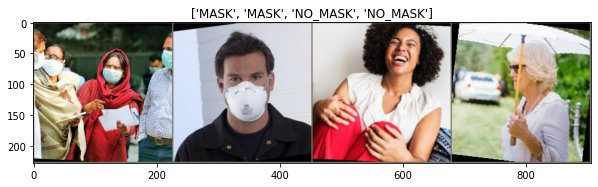

In [232]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,7))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Tracking model training with TensorBoard

In [233]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Train Model

In [235]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=FLAGS.num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(FLAGS.num_epochs):
        print('Epoch {}/{}'.format(epoch, FLAGS.num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            loss_values = []

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                loss_values.append(running_loss/len(dataloaders['train']))
                
                if i % 10 == 9: # every 10 mini-batches...
                    # ...log the running loss
                    writer.add_scalar('training loss',
                                    running_loss / 10,
                                    epoch * len(dataloaders['train']) + i)

                    # ...log a Matplotlib Figure showing the model's predictions on a
                    # random mini-batch
                    writer.add_figure('predictions vs. actuals',
                                    plot_classes_preds(model, inputs, labels),
                                    global_step=epoch * len(dataloaders['train']) + i)
                    
                    
                    running_loss = 0.0
                
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # plot running loss
    plt.plot(np.array(loss_values), 'r')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model

In [236]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(np.transpose(inputs.cpu().data[j],(1,2,0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


## Load a pretrained model: resnet18
 - Finetuning the convnet
 - Load a pretrained model and reset final fully connected layer.


## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2( Mask or No Mask).

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use RestNet18:

In [241]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, FLAGS.num_classes)


model_ft = model_ft.to(device)

# model loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=FLAGS.learning_rate, momentum=FLAGS.momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=FLAGS.gamma)


## Train and evaluate

Epoch 0/9
----------
train Loss: 0.0171 Acc: 0.7541
val Loss: 0.0322 Acc: 0.9109

Epoch 1/9
----------
train Loss: 0.0425 Acc: 0.8645
val Loss: 0.0035 Acc: 0.9211

Epoch 2/9
----------
train Loss: 0.0094 Acc: 0.8907
val Loss: 0.0168 Acc: 0.9669

Epoch 3/9
----------
train Loss: 0.0072 Acc: 0.9093
val Loss: 0.0305 Acc: 0.9440

Epoch 4/9
----------
train Loss: 0.0103 Acc: 0.9027
val Loss: 0.0085 Acc: 0.9211

Epoch 5/9
----------
train Loss: 0.0099 Acc: 0.9246
val Loss: 0.0016 Acc: 0.9695

Epoch 6/9
----------
train Loss: 0.0128 Acc: 0.9180
val Loss: 0.0095 Acc: 0.9567

Epoch 7/9
----------
train Loss: 0.0044 Acc: 0.9410
val Loss: 0.0033 Acc: 0.9720

Epoch 8/9
----------
train Loss: 0.0121 Acc: 0.9366
val Loss: 0.0098 Acc: 0.9746

Epoch 9/9
----------
train Loss: 0.0036 Acc: 0.9377
val Loss: 0.0112 Acc: 0.9720

Training complete in 332m 12s
Best val Acc: 0.974555


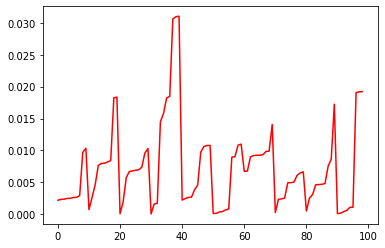

In [242]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=FLAGS.num_epochs)

## Visualize Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


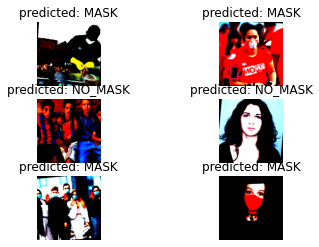

In [244]:
visualize_model(model_ft)

## Confusion Matrix

In [245]:
import seaborn as sns

nb_classes = 2
class_names

['MASK', 'NO_MASK']

### Confusion Matrix on Validation Set

In [246]:
plt.figure(figsize = (9,6))

confusion_matrix_val = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix_val[t.long(), p.long()] += 1

print(confusion_matrix_val)
print(f'Accuracy:{confusion_matrix_val.diag()/confusion_matrix_val.sum(1)}')

tensor([[193.,   0.],
        [ 11., 189.]])
Accuracy:tensor([1.0000, 0.9450])


<Figure size 648x432 with 0 Axes>

Text(0.5, 14.09375, 'Predicted label')

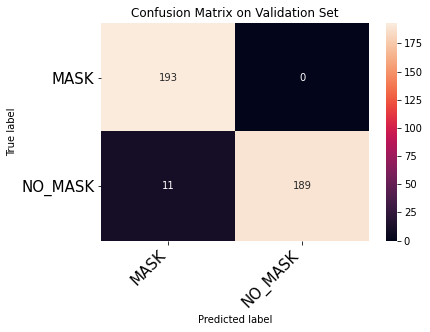

In [251]:
val_cm = pd.DataFrame(confusion_matrix_val, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(val_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')


### Confusion Matrix on Training set 

In [248]:
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(f'Accuracy:{confusion_matrix.diag()/confusion_matrix.sum(1)}')

tensor([[451.,   0.],
        [  0., 464.]])
Accuracy:tensor([1., 1.])


Text(0.5, 14.09375, 'Predicted label')

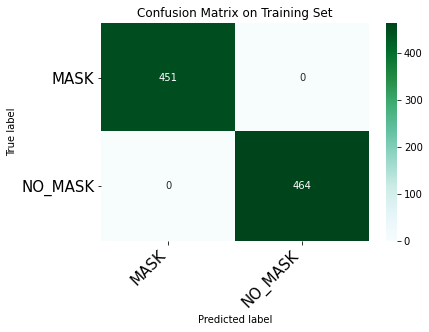

In [250]:
train_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(train_cm, annot=True, fmt="d", cmap='BuGn')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.title('Confusion Matrix on Training Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [254]:
def matplotlib_imshow(img, one_channel=False):
    '''show images'''
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## TensorBoard setup

  - command: tensorboard --logdir=runs/

In [255]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mask_nomask_experiment_1')

## Writing to TensorBoard

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


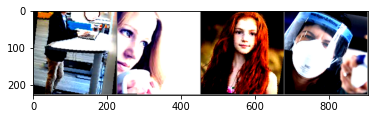

In [256]:
# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('four_mask_nomask_images', img_grid)

## Inspect the model using TensorBoard

In [257]:
writer.add_graph(model_ft, images)
writer.close()

## Run a new image through the model
We can pass multiple image through the model to obtain a prediction as we have in the testing set<br>

## Save and Load Model

In [258]:
def saveModel(path, model):
    '''save model'''
    return torch.save(model, path + "/MaskNoMaskModel.pth")

def saveModel_StateDict(model):
    '''save model dicts'''
    return torch.save(model.state_dict() + 'MaskNoMaskModelState.pth')

def loadModel(path):
    '''load model'''
    model = torch.load(path + '/MaskNoMaskModel.pth')
    return model

In [259]:
saveModel(root, model_ft)

## Evaluate Model

In [260]:
def load(path, fs=__builtins__):
    '''load image'''
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img

def transform(img):
    '''tranform testing image'''
    trn = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225])
    ])
    return trn(img)

def predict(batch, model):
    '''make predictions'''
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted


def batch_predictions(path, model, channel, IMG_WIDTH, IMG_HEIGHT):
    '''make batch predictions'''
    # LOOP OVER IMAGES
    img_objs = [load(x) for x in glob.glob(path)]
    # TRANSFORM IMAGES
    img_tensors = [transform(x) for x in img_objs]
    # LOOP OVER IMG TENSORS
    batches = [batch for batch in img_tensors]
    # MAKE PREDICTIONS ON SINGLE BATCH OF IMAGES
    predictions = [predict(batch.view(1,channel,IMG_HEIGHT,IMG_WIDTH), model) for batch in batches]

    return predictions

In [296]:
def make_predictions(model, root_path, test_path, height, width, channel=3):
    # test image directory
    IMAGE_PATH = test_path + "/*.*"

    # load model
    model = loadModel(root_path)

    # batch predictions
    predictions = batch_predictions(IMAGE_PATH, model, channel, height,width)

    preds = []
    for i in range(len(predictions)):
        pred = predictions[i].item()
        preds.append(pred)

    # create dataframe
    predicted_df = pd.DataFrame(preds, columns=['Target'])

    return predicted_df

In [298]:
model = loadModel(root)

predicted_df = make_predictions(model,root, test_path, FLAGS.IMG_HEIGHT, FLAGS.IMG_WIDTH)

predicted_df.head(10)

,Target
0,0
1,0
2,0
3,1
4,0
5,1
6,0
7,0
8,0
9,1


In [299]:
image_names = pd.DataFrame(img_names, columns=['Images'])

submissions_v1 = pd.concat([image_names, predicted_df], axis=1)

In [306]:
pd.set_option('max_colwidth', 200)
submissions_v1.head(20)

,Images,Target
0,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/jcqewjmnixvdytkvwuvgywcblhvotx.jpg,0
1,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/orzwzwgaccsbeglnbxsitvpxcivdcm.jpg,0
2,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/pbndybjpdykkiinslkpnepifijnsvd.jpg,0
3,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/zuxvwdblfwjpibjexgfglpyreqslhs.jpg,1
4,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/zneawovpezfvxphxdlzgpjhllyxuss.jpg,0
5,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/kmxjicdqvpfpvrhqukkpumdscvgnob.jpg,1
6,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/ufjcnzoabfdevufathmxztkvmlfgmd.jpg,0
7,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/dxkxrtwzulytuhegnxjznhxxsqdvjt.jpg,0
8,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/llecnksnwfhbpbcjzzijseaoxblcbo.jpg,0
9,/Users/tsiameh/Desktop/PhD.MSU/Spring2021/PatternRecognition/project/PatternRecognition/Mask_NoMask/test/ixbtflbbatnitjiveitztqwnjfvidt.jpg,1


## Predictions Count

In [301]:
submissions_v1['Target'].value_counts()

1    258
0    256
Name: Target, dtype: int64

## Save Predictions to File


In [302]:
submissions_v1.to_csv(root + "/submissions_v2_final.csv")